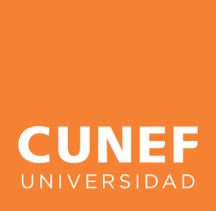


#  <font color=orange> Notebook: Shallow Learning en Series Temporales</font>
## Máster de Ciencia de Datos
### Modelos de Inteligencia Artificial

<b> Profesor: </b> Wolfram Rozas. <b> Departamento: </b> Métodos Cuantitativos
___________________________________________________________________________________________
__Resumen__


Este *cuaderno* describe algunos métodos de regresión de aprendizaje superficial aplicados a las series temporales de consumo y producción de energía (medida en kWh) y % de margen libre de batería (headroom%) con datos de granularidad diaria.

Se aplican modelos de regresión de paquetes Scikit-learn para realizar pronósticos en series temporales. Específicamente, utilizamos SKForecast (*), una biblioteca simple que contiene las clases y funciones necesarias para adaptar cualquier modelo de regresión de Scikit-learn a problemas de pronóstico.

Los modelos de pronóstico autorregresivo recursivo con variables exógenas se desarrollan con las siguientes técnicas de regresión:
<ol>
    <li>Regresión lineal</li>
    <li>Lasso</li>
    <li>Regresión Cresta</li>
    <li>Regresión Cresta Bayesiana</li>
    <li>Bosque Aleatorio</li>
    <li>Aumento de Gradiente Extremo (XGB)</li>
</ol>

(*) Rodrigo, J.A. Escobar Ortiz, J. _Skforecast: pronóstico de series de tiempo con Python y Scikit-learn_, disponible bajo Atribución 4.0 Internacional (CC BY 4.0) en https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python -scikitlearn.html

# Machine Learning Regression models in Time Series

In order to apply machine learning models to forecasting problems, the time series has to be transformed into a matrix in which each value is related to the time window (lags) that precedes it. This is called the _sliding window_

In a time series context, a lag with respect to a time step  t  is defined as the values of the series at previous time steps. For example, lag 1 is the value at time step  t−1  and lag  m  is the value at time step  t−m .


<br>
 
<div>
<img src="attachment:transform_timeseries.gif" width="500"/>
</div>

Time series transformation into a matrix of 5 lags and a vector with the value of the series that follows each row of the matrix.

This type of transformation also allows to include additional variables.

<div>
<img src="attachment:matrix_transformation_with_exog_variable.png" width="500"/>
</div>

Time series transformation including an exogenous variable.
Once data have been rearranged into the new shape, any regression model can be trained to predict the next value (step) of the series. During model training, every row is considered a separate data instance, where values at lags 1, 2, ...  p  are considered predictors for the target quantity of the time series at time step  p+1. SKForecast package builds the dependent variable lags, but not the exogenous variable ones that should be computed during the computation process.

The main complexity of this approach is to generate the correct training matrices for each model, _the sliding window_

<div>
<img src="attachment:diagram_skforecast_multioutput.png" width="700"/>
</div>


Once data have been rearranged into the new shape, any regression model can be trained to predict the next value (step) of the series. During model training, every row is considered a separate data instance, where values at lags 1, 2, ... p are considered predictors for the target quantity of the time series at time step p+1.

<div>
<img src="attachment:diagram-trainig-forecaster.png" width="500"/>
</div>


In [103]:
# Import Packages

# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from cycler import cycler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
%matplotlib inline

# Color Palette

dark_green = '#00523e'
brown = '#2d2572'
violet = '#2d2572'
pale_red = '#d42f01'
dark_blue = '#2d2d8a'
turquoise = '#059899'
pale_green = '#99cb02'
gray = '#808080'
plt.style.use('fivethirtyeight')

# Modeling and Forecasting
# ==============================================================================
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.preprocessing import StandardScaler


from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

import statsmodels.api as sm

# Time & DataTime
# ==============================================================================
import time
import datetime

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [104]:
# DEFINIR los directorios para datos, figuras y modelos
# actualiza el valor de la variable con un valor alfanúmerico con el directorio

#dataset_path = '/home/wrozas/1.0 Dataset/' # TESLA 
#dataset_path = '/home/wrozas/Insync/crozas2@alumno.uned.es/OneDrive Biz/3 Doctorado/0B. Papers & Thesis/00. Cornwall Dataset LEM Data & Analysis/1.0 Dataset/'# UBUNTU
dataset_path = '/workspaces/Prueba-Github/Modelos de Inteligencia Artificial/ACT6/'

#figures_path = '/home/wrozas/2. Jupyter Notebooks/00. Cornwall LEM Notebooks/3. SLM/figures/' # TESLA 
#figures_path = '/home/wrozas/Insync/crozas2@alumno.uned.es/OneDrive Biz/3 Doctorado/0B. Papers & Thesis/00. Cornwall Dataset LEM Data & Analysis/2. Jupyter Notebooks/3. SLM/0. figures/'# UBUNTU
figures_path = '/workspaces/Prueba-Github/Modelos de Inteligencia Artificial/ACT6/figures/'

#models_path = '/home/wrozas/2. Jupyter Notebooks/00. Cornwall LEM Notebooks/3. SLM/models/' # TESLA 
#models_path = '/home/wrozas/Insync/crozas2@alumno.uned.es/OneDrive Biz/3 Doctorado/0B. Papers & Thesis/00. Cornwall Dataset LEM Data & Analysis/2. Jupyter Notebooks/3. SLM/3. models/'# UBUNTU
models_path = '/workspaces/Prueba-Github/Modelos de Inteligencia Artificial/ACT6/models/'

In [105]:
# Get initial time for this notebook
time_init = time.localtime()

In [106]:
dependent_variable = '1'
dependent_variable = input("Dependent Variable: 1 = Consumption kW, 2=Production kW, 3 = Headroom% " )

if dependent_variable == '1':
    dependent_variable = ".B03 Consumption kWh"
elif dependent_variable == '2':
    dependent_variable = ".B04 Production kWh"
else:
    dependent_variable = ".B15 Headroom"

print(dependent_variable)

.B15 Headroom


In [107]:
selected_regressor = '1'
selected_regressor = input("Select Regressor: 1 = Linear Regression, 2 = Lasso, 3 = Ridge Regression, 4 = Bayesian Ridge Regression, 5 = Random Forest, 6 = XGB " )
alpha = 0
if selected_regressor == '1':
    regressor_named = "Linear Regression"
    
elif selected_regressor == '2':

    alpha = input("alpha: ")
    if alpha == "":
        alpha = 0.1
    regressor_named = "Lasso"
    
elif selected_regressor == '3':

    alpha = input("alpha: ")
    if alpha == "":
        alpha = 0.5
    regressor_named = "Ridge Regression"
    
elif selected_regressor == '4':
    regressor_named = "Bayesian Ridge Regression"
    
elif selected_regressor == '5':
    regressor_named = "Random Forest Regressor"
    
else:
    regressor_named = "XGBoost"

if alpha != 0:
    print(regressor_named + " (alpha = " + str(alpha) + ")")
else:
    print(regressor_named)

XGBoost


## 1. Cornwall LEM Hourly Data Loading and Preparation

In [108]:
df_multivar = pd.DataFrame()

In [109]:
# Read t_msb1m_sites_metadata_date_cluster_meteo table
# This table is the cross of KPIs by MySonnenBatterie (t_msb1m)at minute granularity level with t_sites (information on BESS and metadata information 
# (information about the UNIT, BESS, APPLIANCES, DER, EV, BILL ), having the cluster label, and cross with weather information (t_weatherforecasts)
# Information is agggregated at hour level having the minute information and filtered in the annual period 30.4.2019-31.3.2020


df_multivar = pd.read_csv(dataset_path+'t_msb1m_sites_metadata_date_cluster_meteo.csv', delimiter=';')

In [110]:
# Cleanse NaN values
df_multivar.fillna(axis = 1, value= 0, inplace=True)

In [111]:
# Removing unnecessary columns

df_multivar.drop(columns=df_multivar.columns[2:22], inplace=True)
df_multivar.drop(columns=df_multivar.columns[17:71], inplace=True)

In [112]:
# Convert site into integer, date into string and rename it

df_multivar['01.01 UNIT site']=df_multivar['01.01 UNIT site'].astype(int)
df_multivar['date']=df_multivar['date'].astype(str)

# Convert object series in float

for i in range(2, 23):
    df_multivar[df_multivar.columns[i]]=df_multivar[df_multivar.columns[i]].astype(float)

In [113]:
df_multivar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31955 entries, 0 to 31954
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   01.01 UNIT site                 31955 non-null  int64  
 1   date                            31955 non-null  object 
 2   .B01 Discharge kWh              31955 non-null  float64
 3   .B02 Charge kWh                 31955 non-null  float64
 4   .B03 Consumption kWh            31955 non-null  float64
 5   .B04 Production kWh             31955 non-null  float64
 6   .B05 Grid Export kWh            31955 non-null  float64
 7   .B06 Grid Import kWh            31955 non-null  float64
 8   .B07 PV Charge kWh              31955 non-null  float64
 9   .B08 PV Consumption kWh         31955 non-null  float64
 10  .B09 PV Export kWh              31955 non-null  float64
 11  .B10 Grid Discharge kWh         31955 non-null  float64
 12  .B11 Grid Charge kWh            

### 1.1. Dataset Variable Selection

In [114]:
# Aggregate by date
df_multivar = df_multivar.groupby(['date'], dropna=False).mean()


# Drop unnecessary columns
df_multivar = df_multivar.drop(['01.01 UNIT site'], axis=1)
df_multivar = df_multivar.drop(['.B14 SOC'], axis=1)

In [115]:
df_multivar = df_multivar.reset_index(drop=True)

In [116]:
df_multivar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   .B01 Discharge kWh              357 non-null    float64
 1   .B02 Charge kWh                 357 non-null    float64
 2   .B03 Consumption kWh            357 non-null    float64
 3   .B04 Production kWh             357 non-null    float64
 4   .B05 Grid Export kWh            357 non-null    float64
 5   .B06 Grid Import kWh            357 non-null    float64
 6   .B07 PV Charge kWh              357 non-null    float64
 7   .B08 PV Consumption kWh         357 non-null    float64
 8   .B09 PV Export kWh              357 non-null    float64
 9   .B10 Grid Discharge kWh         357 non-null    float64
 10  .B11 Grid Charge kWh            357 non-null    float64
 11  .B12 Grid Consumption kWh       357 non-null    float64
 12  .B13 Consumption Discharge kWh  357 

In [117]:
# Check missing values

print(f'Number of rows with missing values: {df_multivar.isnull().values.ravel().sum()}')



Number of rows with missing values: 0


### 1.2 Data Partitioning: Training and Testing Subsets

Dataset is partitioned in three subsets: one for training with 70% sample size, the second for testing with about 30% sample size. The third portion is for prediction and will have the same number of elements of the output window (steps). Our output window (steps) is 7 days.

In [118]:
steps = 7  # forecasting horizon as output window

In [119]:
lagged_variables = [
 '.B01 Discharge kWh',
 '.B02 Charge kWh',
 '.B03 Consumption kWh',
 '.B04 Production kWh',
 '.B05 Grid Export kWh',
 '.B06 Grid Import kWh',
 '.B07 PV Charge kWh',
 '.B08 PV Consumption kWh',
 '.B09 PV Export kWh',
 '.B10 Grid Discharge kWh',
 '.B11 Grid Charge kWh',
 '.B12 Grid Consumption kWh',
 '.B13 Consumption Discharge kWh',
 '.B15 Headroom',
 'precipitation_Mean',
 'precipitation_probability_Mean',
 'wind_direction_Mean',
 'wind_speed_Mean',
 'solar_radiation_Mean',
 'sunshine_duration_Mean'
 ]  

# Creation of Lagged Exogenous

for i in range(0, len(lagged_variables)):
    for j in range(1, steps+1):
        df_multivar[lagged_variables[i]+'_lag_' + str(j)] = df_multivar[lagged_variables[i]].shift(j)

In [120]:
# Removing exogenous at time t 

drop_cols = ['.B01 Discharge kWh',
 '.B02 Charge kWh',
 '.B05 Grid Export kWh',
 '.B06 Grid Import kWh',
 '.B07 PV Charge kWh',
 '.B08 PV Consumption kWh',
 '.B09 PV Export kWh',
 '.B10 Grid Discharge kWh',
 '.B11 Grid Charge kWh',
 '.B12 Grid Consumption kWh',
 '.B13 Consumption Discharge kWh',
 'precipitation_Mean',
 'precipitation_probability_Mean',
 'wind_direction_Mean',
 'wind_speed_Mean',
 'solar_radiation_Mean',
 'sunshine_duration_Mean']

if dependent_variable == '.B03 Consumption kWh':
    
    drop_cols.append('.B04 Production kWh')
    drop_cols.append('.B15 Headroom')

elif dependent_variable == '.B04 Production kWh':

    drop_cols.append('.B03 Consumption kWh')
    drop_cols.append('.B15 Headroom')
  
else:
    
    drop_cols.append('.B04 Production kWh')
    drop_cols.append('.B03 Consumption kWh')

df_multivar = df_multivar.drop(drop_cols, axis=1)
cols_df_multivar = df_multivar.columns.to_list()
exog_variables  = cols_df_multivar[1:len(cols_df_multivar)]

In [121]:
# Cleanse NaN values
df_multivar = df_multivar.fillna(df_multivar.median())

In [122]:
df_multivar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Columns: 141 entries, .B15 Headroom to sunshine_duration_Mean_lag_7
dtypes: float64(141)
memory usage: 393.4 KB


In [123]:
# Creating train-test-predict subsets 
# ==============================================================================

partition = round(len(df_multivar)*0.7) # 70% training subset
test_size = len(df_multivar) - partition # 30% testing subset

data_train = df_multivar[:partition] # training subset
data_test  = df_multivar[partition:len( df_multivar)-steps] # testing subset = 30% - steps
data_predict = df_multivar[len( df_multivar)-steps:] # predicting subset for exogenous variables (steps)

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")
print(f"Total dataset size  (n={ df_multivar.shape[0] })")

Train dates : 0 --- 249  (n=250)
Test dates  : 250 --- 349  (n=100)
Total dataset size  (n=357)


In [124]:
# Cleanse NaN values
data_train.fillna(axis = 1, value= 0, inplace=True)
data_test.fillna(axis = 1, value= 0, inplace=True)
data_predict.fillna(axis = 1, value= 0, inplace=True)

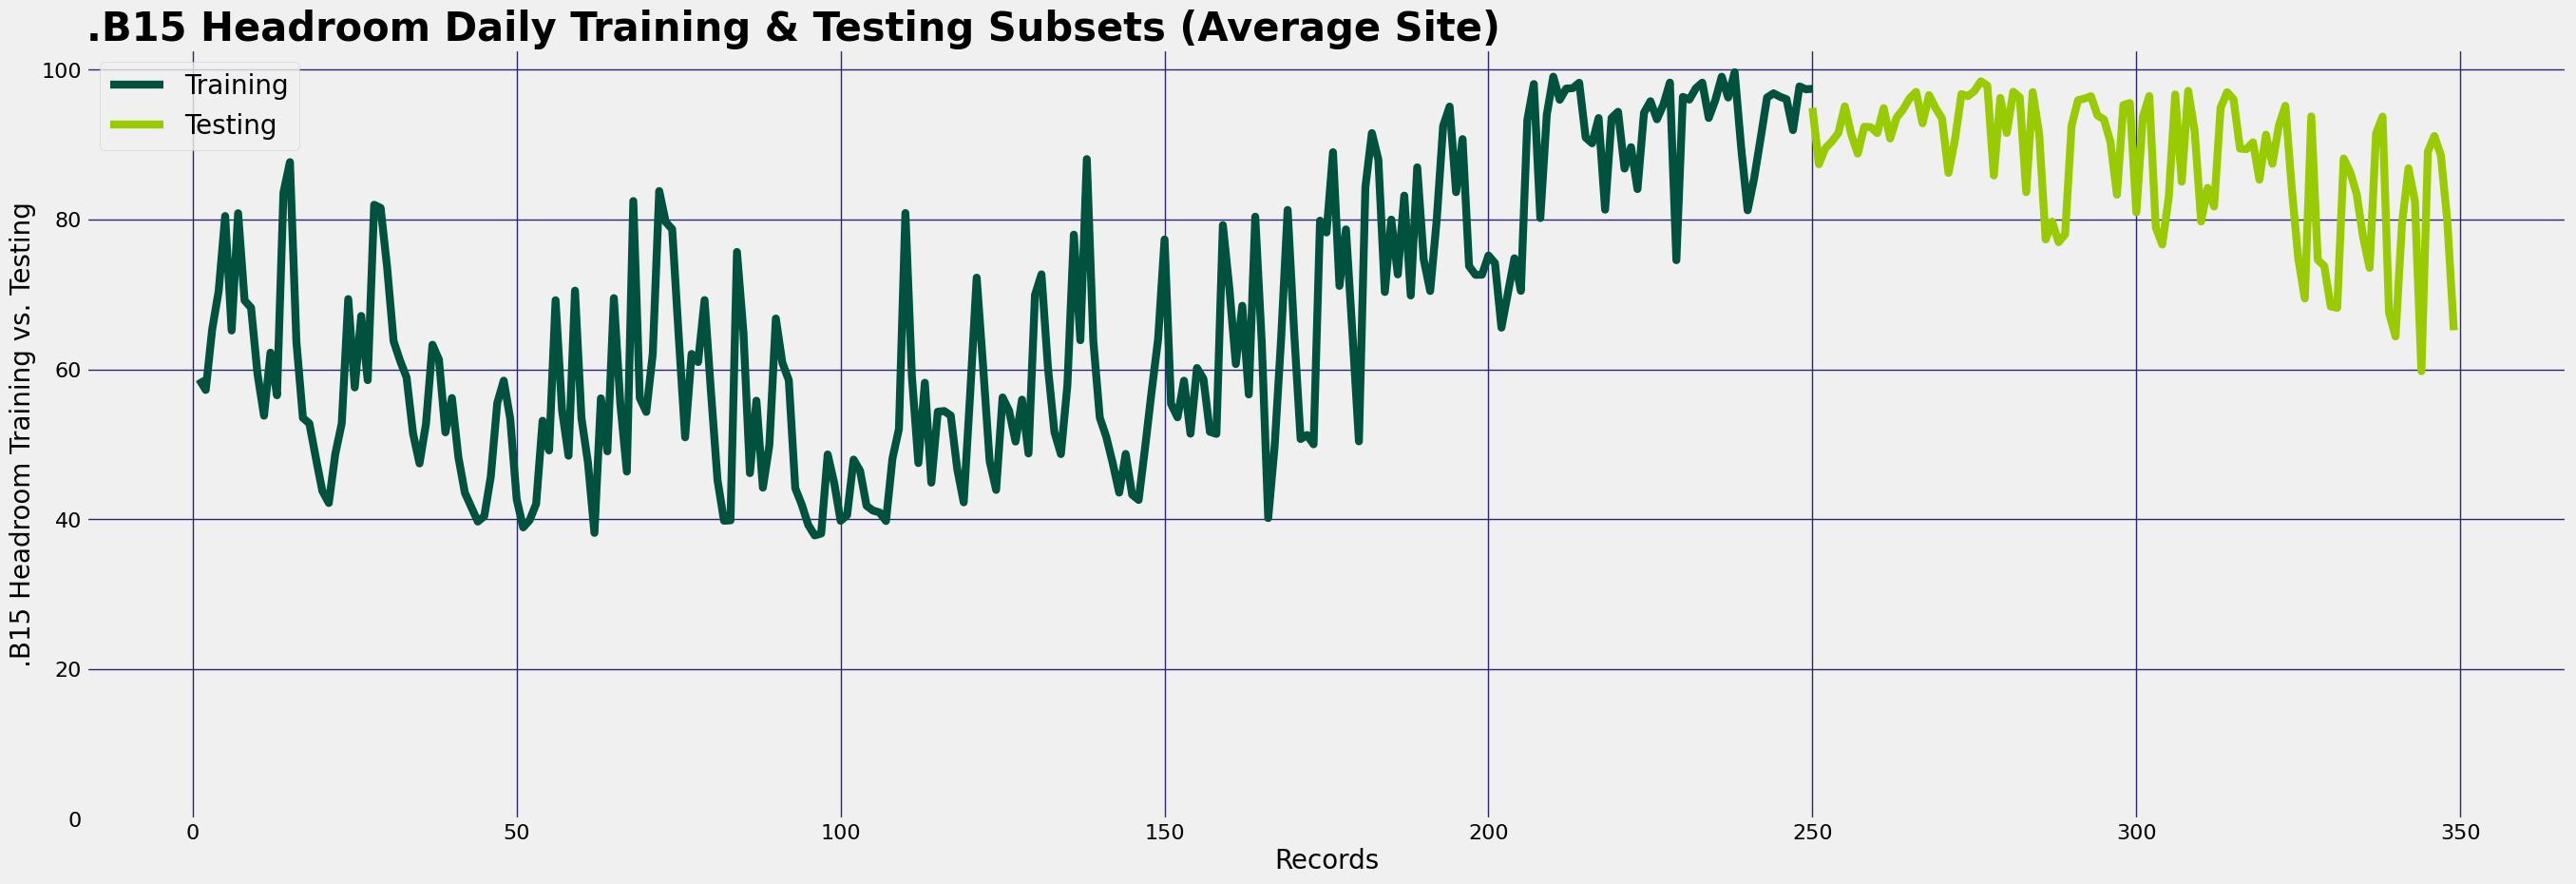

In [125]:
# Plot Training and Testing Dependent Variable

plt.figure(figsize=(30, 10))

x_train_axis = data_train.index
x_test_axis = data_test.index

x_axis = np.arange(1, len(data_train.index)+1,1)
y_axis = np.arange(len(data_train.index),len(data_train.index)+len(data_test.index),1)

plt.title(dependent_variable + ' Daily Training & Testing Subsets (Average Site)', fontsize=30, loc = 'left', fontweight="bold")

plt.plot(x_axis, data_train[dependent_variable], linewidth=6, color = dark_green) 
plt.plot(y_axis, data_test[dependent_variable], linewidth=6, color = pale_green) 

plt.ylim(bottom=0)
plt.ylabel(dependent_variable + ' Training vs. Testing', fontsize=20)
plt.xlabel("Records", fontsize=20)


plt.xticks(fontsize=16) 
plt.yticks(fontsize=16)
plt.grid(visible = True, color =brown, axis ='both')

plt.legend(["Training", "Testing"], loc='best', fontsize=20)

fname = figures_path + dependent_variable[2:len(dependent_variable)] + "_" + "Daily_Training_Testing_Subsets_Average_Site.png"
plt.savefig(fname, format='png')

plt.show()


### 1.3 Data Standardization

Data is re-scaled standardizing the numerical columns by presenting a mean of 0 and a standard deviation of 1 thus all elements independently of their dimension can be compared.

The pre-processing transformer StandScaler() from Scikit-learn package is directly applied in the Forecaster Class that will run the regression models. 

## 2. Daily Data Description

### 2.1. Dependent variable plot

We plot the dependent variable at daily granularity level

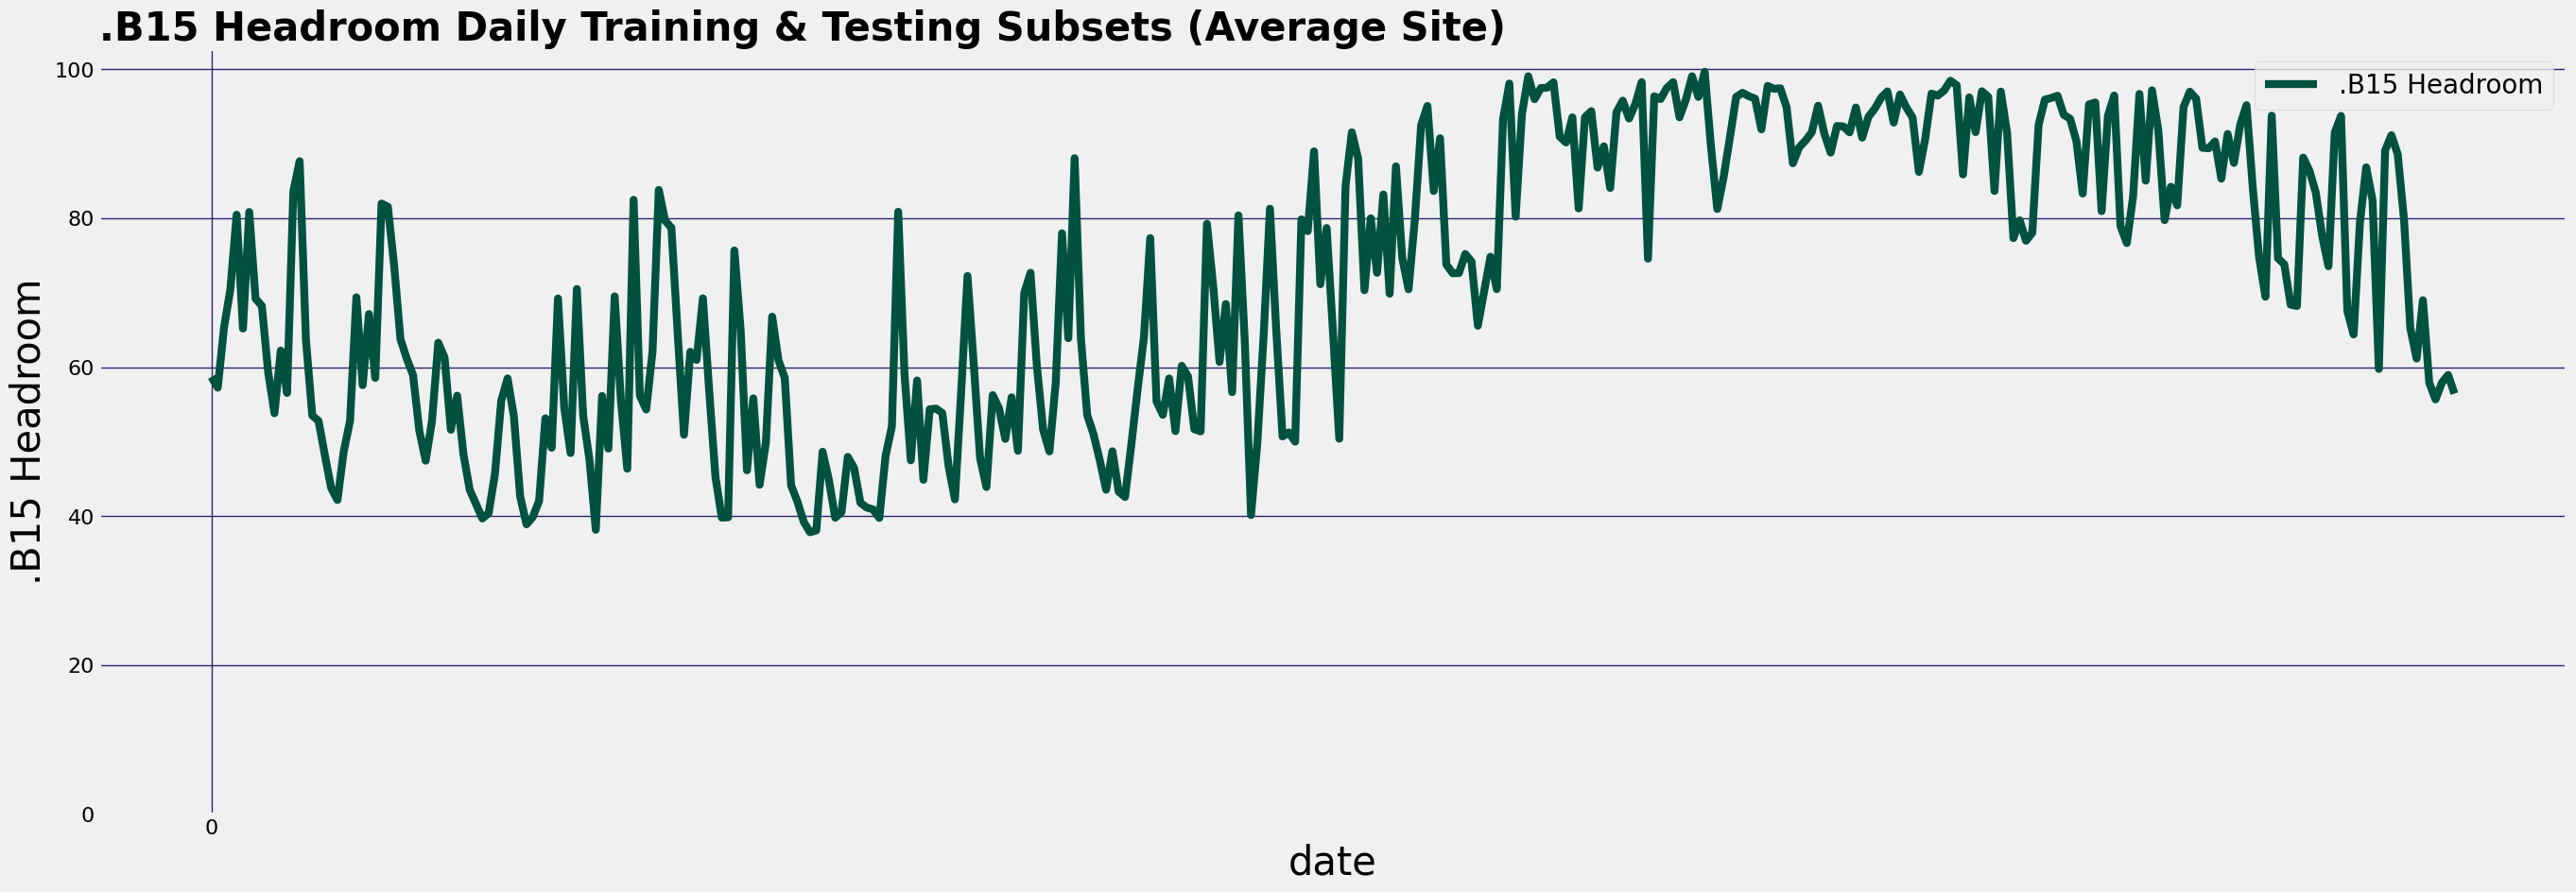

In [126]:
# Plotting the dependent variable
fig, ax = plt.subplots(figsize=(30,10))

ax.plot(df_multivar.index,df_multivar[dependent_variable],color=dark_green,linewidth=6, label=dependent_variable)

plt.title(dependent_variable + " Daily Training & Testing Subsets (Average Site)", fontsize = 30,  loc = 'left', fontweight="bold")

locs, labels = plt.xticks() 
newlocs  = np.arange(0, len(locs), 50)
newlabels = []

for i in range(0, len(newlocs)): 
    newlabels.append(df_multivar.index[newlocs[i]])
    

ax.set_ylim(bottom=0)
plt.ylabel(dependent_variable, size=30)
plt.xlabel("date", size=30)
plt.xticks(fontsize=16, ticks=newlocs, labels=newlabels, minor = False )
plt.yticks(fontsize=16)
plt.legend(loc="best",fontsize="20")
plt.grid(visible = True, color =brown, axis ='both')

fname = figures_path + dependent_variable[2:len(dependent_variable)] + "_by_date.png"
plt.savefig(fname, format='png')

plt.show()

### 2.2. Autocorrelation plots

Autocorrelation and partial autocorrelation function are plotted to show the dependent's variable autorregresive behavior that justify the usage of autorregresive/recursive forecasting methods.

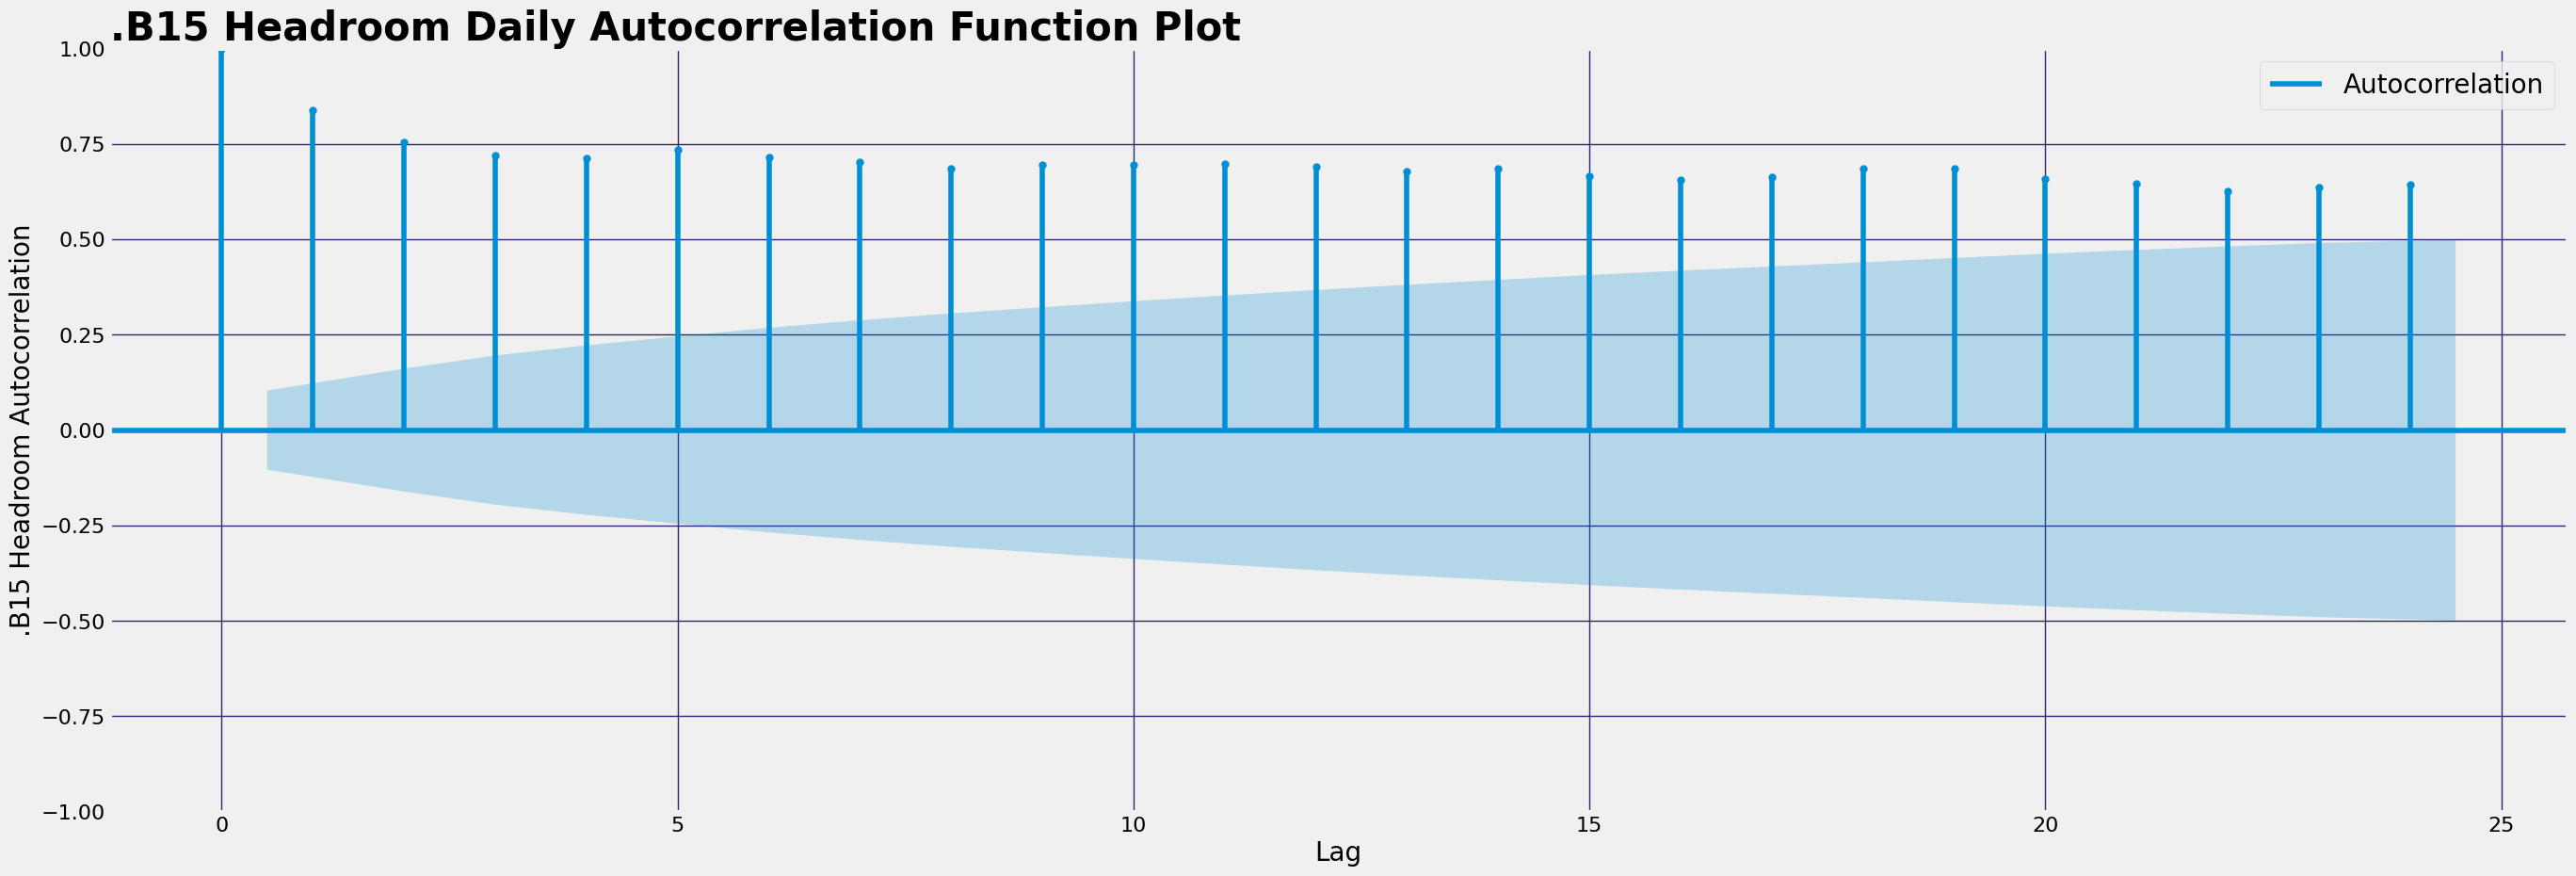

In [127]:
# Autocorrelation plot
# ======================================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30, 10), sharex=True)

sm.graphics.tsa.plot_acf(df_multivar[dependent_variable],ax=ax, title = '', lags=24)

plt.title(dependent_variable + ' Daily Autocorrelation Function Plot', fontsize=30, loc = 'left', fontweight="bold")

plt.ylabel(dependent_variable + ' Autocorrelation', fontsize=20)
plt.xlabel("Lag", fontsize=20)


plt.xticks(fontsize=16) 
plt.yticks(fontsize=16)
plt.grid(visible = True, color =brown, axis ='both')

plt.legend(["Autocorrelation"], loc='best', fontsize=20)

fname = figures_path + dependent_variable[2:len(dependent_variable)] + '_Daily_Autocorrelation_Function_Plot.png'
plt.savefig(fname, format='png')

plt.show()

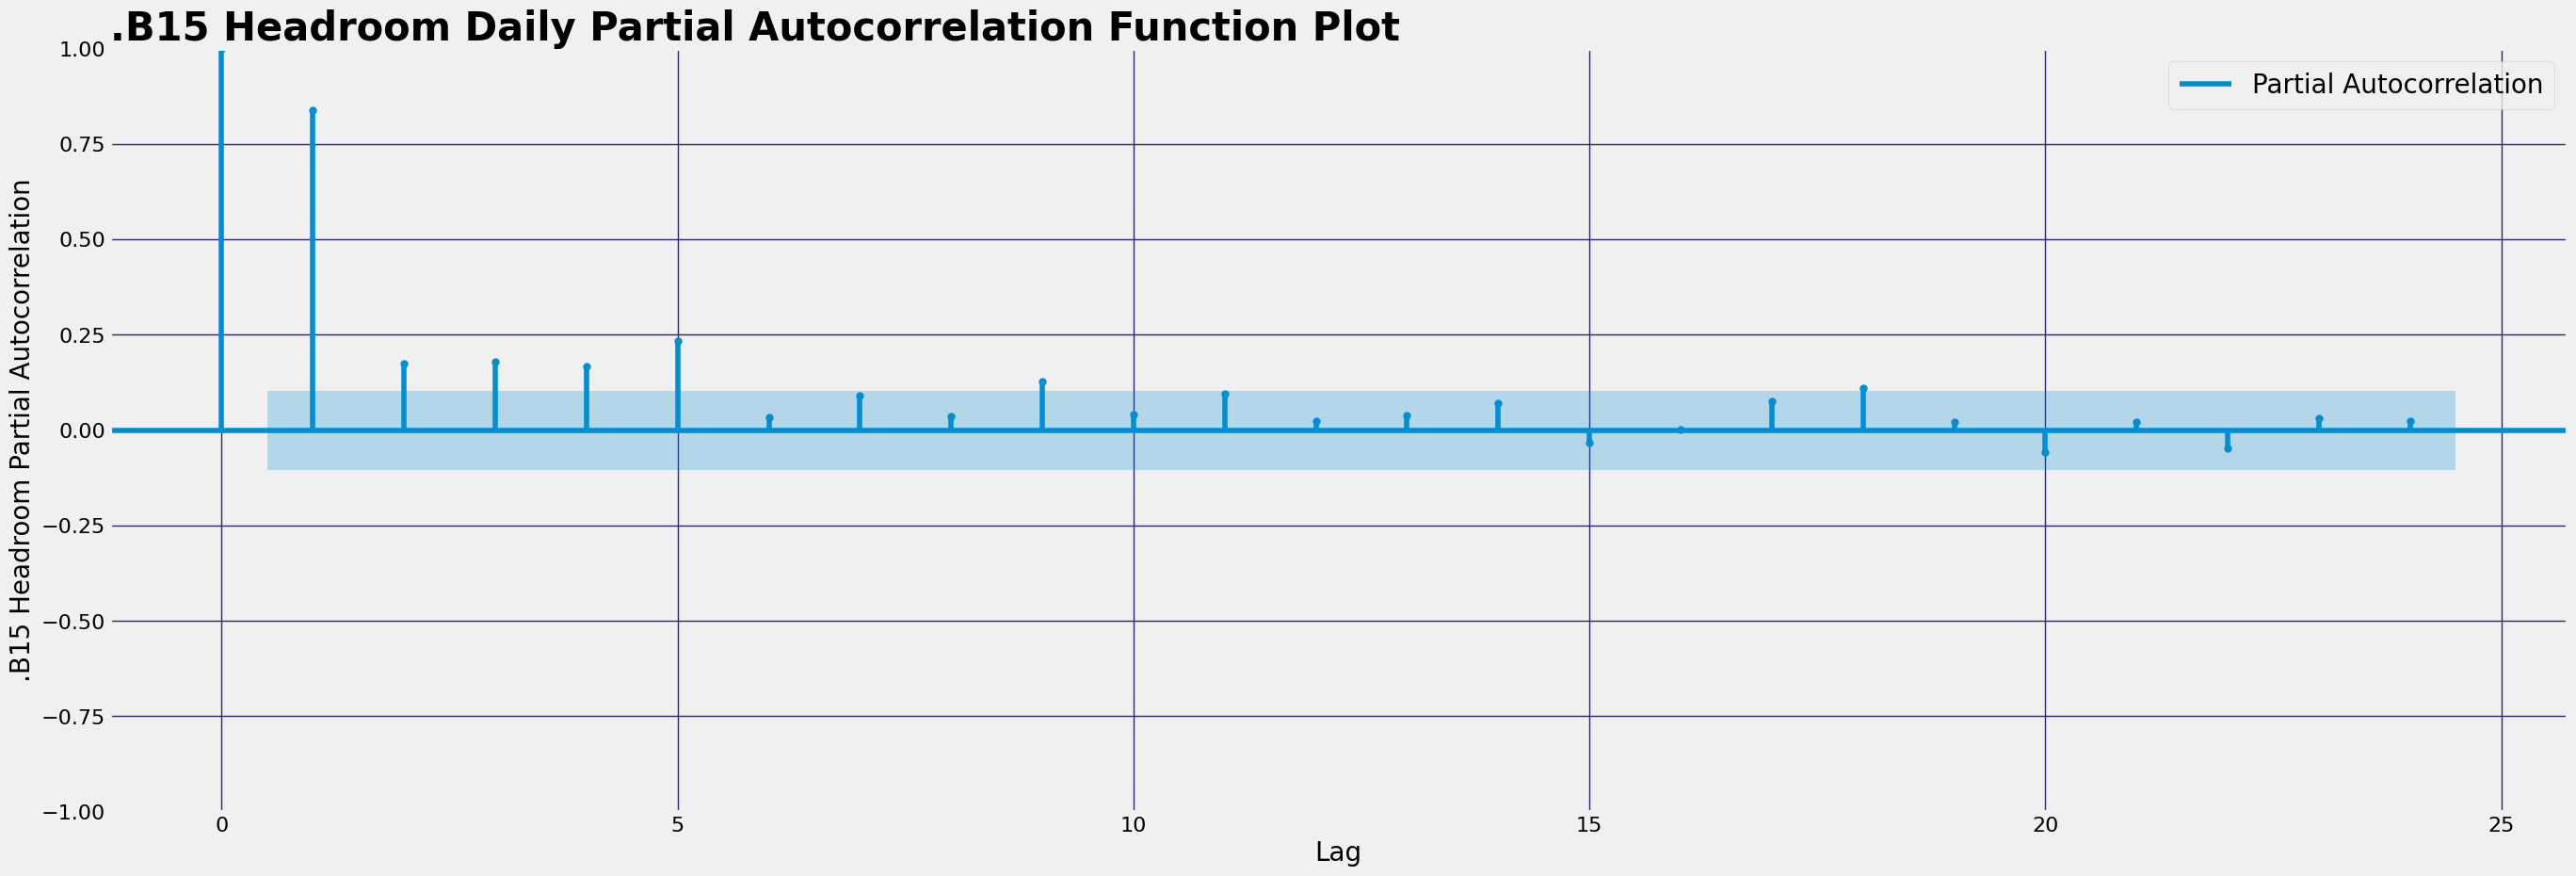

In [128]:
# Partial Autocorrelation plot
# ======================================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30, 10), sharex=True)

sm.graphics.tsa.plot_pacf(df_multivar[dependent_variable],ax=ax, title = '', lags=24, method='ywm')

plt.title(dependent_variable + ' Daily Partial Autocorrelation Function Plot', fontsize=30, loc = 'left', fontweight="bold")

plt.ylabel(dependent_variable + ' Partial Autocorrelation', fontsize=20)
plt.xlabel("Lag", fontsize=20)


plt.xticks(fontsize=16) 
plt.yticks(fontsize=16)
plt.grid(visible = True, color =brown, axis ='both')

plt.legend(["Partial Autocorrelation"], loc='best', fontsize=20)

fname = figures_path + dependent_variable[2:len(dependent_variable)] + '_Daily_Partial_Autocorrelation_Function_Plot.png'
plt.savefig(fname, format='png')

plt.show()

## 3. Recursive Forecasting Models withe the Sliding Window

To predict variables at t$_n$ we need to have variables at t$_{n−1}$ whose values are unknown. A recursive process is applied in which, each new prediction, is based on the previous one. This process is called _recursive forecasting_.


The model specification is the following:


$\qquad\qquad$ Dependent Variable$_t = f($Dependent Variable$_{t−1} \quad + \quad $exogenous variables$_{t−1})$ + $\epsilon_t$

<br>
 
<div>
<img src="attachment:diagram-recursive-mutistep-forecasting.png" width="500"/>
</div>

### 3.1. Forecaster creation and training

With the ForecasterAutoreg class, a model is created and trained from a __SciKit Learn__ regressor with a time window of 24 lags (input window). This means that the model uses the previous 24 hours as predictors. We also add the lagged exogenous variables as inputs of our models. We train the selected regressor with default options to produce an outpput window of 24 leads (we will predict the following 24 hours):  

<ol>
    <li>Ordinary Least Squares Regression</li>
    <li>Lasso (alpha = 0.1)</li>
    <li>Ridge Regression (alpha = 0.5)</li>
    <li>Bayesian Ridge Regression</li>
    <li>Random Forest (n_estimators = 100, max_depth = 5)</li>  
    <li>Gradient Boosting Regressor (n_estimators = 100, max_depth = 5, learning_rate = 0.1)</li>  
</ol>

#### 3.1.1 Ordinary Least Squares Regression

According to scikit-learn "_LinearRegression fits a linear model with coefficients  to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation. Mathematically it solves a problem of the form:"_

 
<p style="text-align: center;">$\min_{w} || X w - y||_2^2$</p>

#### 3.1.2 Lasso (L1 Norm)

According to scikit-learn "_The Lasso (Least Absolute Shrinkage and Selection Operator) is a linear model that estimates sparse coefficients. It is useful in some contexts due to its tendency to prefer solutions with fewer non-zero coefficients, effectively reducing the number of features upon which the given solution is dependent._

_Mathematically, it consists of a linear model with an added regularization term. The objective function to minimize is:_

<p style="text-align: center;">$\min_{w} { \frac{1}{2n_{\text{samples}}} ||X w - y||_2 ^ 2 + \alpha ||w||_1}$</p>
 
_The lasso estimate thus solves the minimization of the least-squares penalty with  added, where $\alpha$ is a constant and $||w||_1$ is the norm of the coefficient vector._ "

#### 3.1.3 Ridge Regression (L2 Norm)

According to scikit-learn "_Ridge regression addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of the coefficients. The ridge coefficients minimize a penalized residual sum of squares:_

 
<p style="text-align: center;">$\min_{w} || X w - y||_2^2 + \alpha ||w||_2^2$</p>

_The complexity parameter $\alpha \ge 0$ controls the amount of shrinkage: the larger the value of 
$\alpha$, the greater the amount of shrinkage and thus the coefficients become more robust to collinearity._ "

<br>
<div>
<img src=".\lasso-ridge.png" width="500"/>
</div>

#### 3.1.4 Bayesian Ridge Regression

According to scikit-learn "_BayesianRidge estimates a probabilistic model of the regression problem as described above. The prior for the coefficient w is given by a spherical Gaussian:_  $p(w|\lambda) = \mathcal{N}(w|0,\lambda^{-1}\mathbf{I}_{p})$

_The priors over $\alpha$ and $\lambda$ are chosen to be gamma distributions, the conjugate prior for the precision of the Gaussian. The resulting model is called Bayesian Ridge Regression, and is similar to the classical Ridge. The parameters $w,\alpha$ and $\lambda$ are estimated jointly during the fit of the model, the regularization parameters $\alpha$ and $\lambda$ being estimated by maximizing the log marginal likelihood._
_There are four more hyperparameters, $\alpha_1, \alpha_2, \lambda_1, and \lambda_2$ of the gamma prior distributions over $\alpha$ and $\lambda$. These are usually chosen to be non-informative. By default $\alpha_1 = \alpha_2 =  \lambda_1 = \lambda_2 = 10^{-6}$_ "

<br>
<div>
<img src=".\bayesian.png" width="700"/>
</div>


#### 3.1.5 Random Forest

According to scikit-learn "_in random forests each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set. Furthermore, when splitting each node during the construction of a tree, the best split is found either from all input features or a random subset of size max_features._

_The purpose of these two sources of randomness is to decrease the variance of the forest estimator. Indeed, individual decision trees typically exhibit high variance and tend to overfit. The injected randomness in forests yield decision trees with somewhat decoupled prediction errors. By taking an average of those predictions, some errors can cancel out. Random forests achieve a reduced variance by combining diverse trees, sometimes at the cost of a slight increase in bias. In practice the variance reduction is often significant hence yielding an overall better model._

_The scikit-learn implementation combines classifiers by averaging their probabilistic prediction, instead of letting each classifier vote for a single class._

_The main parameters to adjust when using these methods is_ __n_estimators__ _(the former is the number of trees in the forest) and_ __max_features__ _(size of the random subsets of features to consider when splitting a node)._ "

<br>
<div>
<img src=".\rt.png" width="400"/>
</div>

#### 3.1.6 Gradient Boosting Regressor

According to scikit-learn "_Gradient Tree Boosting is a generalization of boosting to arbitrary differentiable loss functions. GBDT is an accurate and effective off-the-shelf procedure that can be used for regression problems. GradientBoostingRegressor is useful when the number of samples is larger than tens of thousands of samples. This method has built-in support for missing values, which avoids the need for an imputer._

_The 2 most important parameters of these estimators are_ __n_estimators__  _(number of weak learners) and_ __learning_rate__ _(hyperparameter that controls overfitting via shrinkage)._ "

GBRT regressors are additive models whose prediction $\hat{y}_i$ for a given input  is of the following form:

<p style="text-align: center;">$\hat{y}_i = F_M(x_i) = \sum_{m=1}^{M} h_m(x_i)$</p>
 
where the $h_m$ are estimators called weak learners in the context of boosting. Gradient Tree Boosting uses decision tree regressors of fixed size as weak learners. The constant M corresponds to the __n_estimators__ parameter.

Similar to other boosting algorithms, a GBRT is built in a greedy fashion:

<p style="text-align: center;">$F_m(x) = F_{m-1}(x) + h_m(x)$</p>

where the newly added tree $h_m$ is fitted in order to minimize a sum of losses $L_m$, given the previous ensemble $F_{m-1}$:

<p style="text-align: center;">$h_m =  \arg\min_{h} L_m = \arg\min_{h} \sum_{i=1}^{n} l(y_i, F_{m-1}(x_i) + h(x_i))$</p>


 
where $l(y_i, F(x_i))$ is defined by the __loss__ parameter.

By default, the initial model  is chosen as the constant that minimizes the loss: for a least-squares loss, this is the empirical mean of the target values. 

Using a first-order Taylor approximation, the value of  can be approximated as follows:

<p style="text-align: center;">$
l(y_i, F_{m-1}(x_i) + h_m(x_i)) \approx
l(y_i, F_{m-1}(x_i))
+ h_m(x_i)
\left[ \frac{\partial l(y_i, F(x_i))}{\partial F(x_i)} \right]_{F=F_{m - 1}}$</p>

The quantity $\left[ \frac{\partial l(y_i, F(x_i))}{\partial F(x_i)} \right]_{F=F_{m - 1}}$ is the derivative of the loss with respect to its second parameter, evaluated at . It is easy to compute for any given  in a closed form since the loss is differentiable. It is denoted by $g_i$

Removing the constant terms, we have:

<p style="text-align: center;">$h_m \approx \arg\min_{h} \sum_{i=1}^{n} h(x_i) g_i$</p>

This is minimized if  is fitted to predict a value that is proportional to the negative gradient . Therefore, at each iteration, the estimator  is fitted to predict the negative gradients of the samples. The gradients are updated at each iteration. This can be considered as some kind of gradient descent in a functional space.

<br>
<div>
<img src=".\xgb.png" width="500"/>
</div>


In [129]:
regressor_named

'XGBoost'

In [130]:
# Options for other regressors included in Scikit-Learn: 
# 1-LinearRegression, 2-Lasso, 3-RidgeRegression, 4-ElasticNet, 5-Random Forest, 6-XGBRegressor

if regressor_named == "Linear Regression":
    selected_regressor = LinearRegression()    
    
elif regressor_named ==  "Lasso":
    selected_regressor = Lasso(alpha=alpha)
    
elif regressor_named == "Ridge Regression":
    selected_regressor = Ridge(alpha=alpha)
    
elif regressor_named ==  "Bayesian Ridge Regression":
    selected_regressor = BayesianRidge()
    
elif regressor_named == "Random Forest Regressor":
    
    selected_regressor = RandomForestRegressor(random_state=123, max_features=10)
    
else:
    
    selected_regressor = GradientBoostingRegressor(random_state=123, max_features=10)

print(selected_regressor)

GradientBoostingRegressor(max_features=10, random_state=123)


In [131]:
lags = 7   # lags horizon as input window

In [132]:
# input X contains Nans
data_train.fillna(axis = 1, value= 0, inplace=True)

In [133]:
# remove index

#data_train = data_train.reset_index(drop=True)

In [134]:
# Create and train RF forecaster 
# We utilize the pre-processing StandardScaler() from Scikit-learn package directly in the SKForecast package
# ===========================================================================================================

if regressor_named == "Linear Regression" or regressor_named ==  "Lasso" or regressor_named == "Ridge Regression" or regressor_named ==  "Bayesian Ridge Regression":
    
    forecaster = ForecasterAutoreg(
                regressor = selected_regressor,
                lags      = lags,
                transformer_y = StandardScaler(),
                transformer_exog = StandardScaler()
             )

    forecaster.fit(y=data_train[dependent_variable])
        
elif regressor_named == "Random Forest Regressor":
    
    forecaster = ForecasterAutoreg(
                regressor = selected_regressor,
                lags      = lags,
                transformer_y = StandardScaler(),
                transformer_exog = StandardScaler()
             )

    forecaster.fit(y=data_train[dependent_variable], exog=data_train[exog_variables])
       
elif regressor_named == "XGBoost":
    
    forecaster = ForecasterAutoreg(
                 regressor = selected_regressor, #GradientBoostingRegressor(random_state=123, max_features=10),
                 lags = lags,
                 transformer_y = StandardScaler(),
                 transformer_exog = StandardScaler()
             )
    forecaster.fit(y=data_train[dependent_variable], exog=data_train[exog_variables])

forecaster

ForecasterAutoreg 
Regressor: GradientBoostingRegressor(max_features=10, random_state=123) 
Lags: [1 2 3 4 5 6 7] 
Transformer for y: StandardScaler() 
Transformer for exog: StandardScaler() 
Window size: 7 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['.B01 Discharge kWh_lag_1', '.B01 Discharge kWh_lag_2', '.B01 Discharge kWh_lag_3', '.B01 Discharge kWh_lag_4', '.B01 Discharge kWh_lag_5', '.B01 Discharge kWh_lag_6', '.B01 Discharge kWh_lag_7', '.B02 Charge kWh_lag_1', '.B02 Charge kWh_lag_2', '.B02 Charge kWh_lag_3', '.B02 Charge kWh_lag_4', '.B02 Charge kWh_lag_5', '.B02 Charge kWh_lag_6', '.B02 Charge kWh_lag_7', '.B03 Consumption kWh_lag_1', '.B03 Consumption kWh_lag_2', '.B03 Consumption kWh_lag_3', '.B03 Consumption kWh_lag_4', '.B03 Consumption kWh_lag_5', '.B03 Consumption kWh_lag_6', '.B03 Consumption kWh_lag_7', '.B04 Production kWh_lag_1',

In [135]:
# Number of exogenous variables
len(exog_variables)

140

In [136]:
# Making predictions
# ==============================================================================
# predict(self, steps, last_window=None, exog=None)
# Predict n steps ahead. It is an recursive process in which, each prediction, is used as a predictor 
# for the next step. 

if regressor_named == "Linear Regression" or regressor_named ==  "Lasso" or regressor_named == "Ridge Regression" or regressor_named ==  "Bayesian Ridge Regression":

    predictions = forecaster.predict_interval(steps=steps, interval = [5, 95], random_state = 123, n_boot=500)
        
elif regressor_named == "Random Forest Regressor" or regressor_named == "XGBoost":
    
    predictions = forecaster.predict(steps=steps, exog=data_test[exog_variables])
       
        

In [137]:
fname = figures_path + dependent_variable[2:len(dependent_variable)] + '_' + regressor_named + '_Daily_Forecasting_Testing_Subsets_Average_Site.png'

In [138]:
fname

'/workspaces/Prueba-Github/Modelos de Inteligencia Artificial/ACT6/figures/15 Headroom_XGBoost_Daily_Forecasting_Testing_Subsets_Average_Site.png'

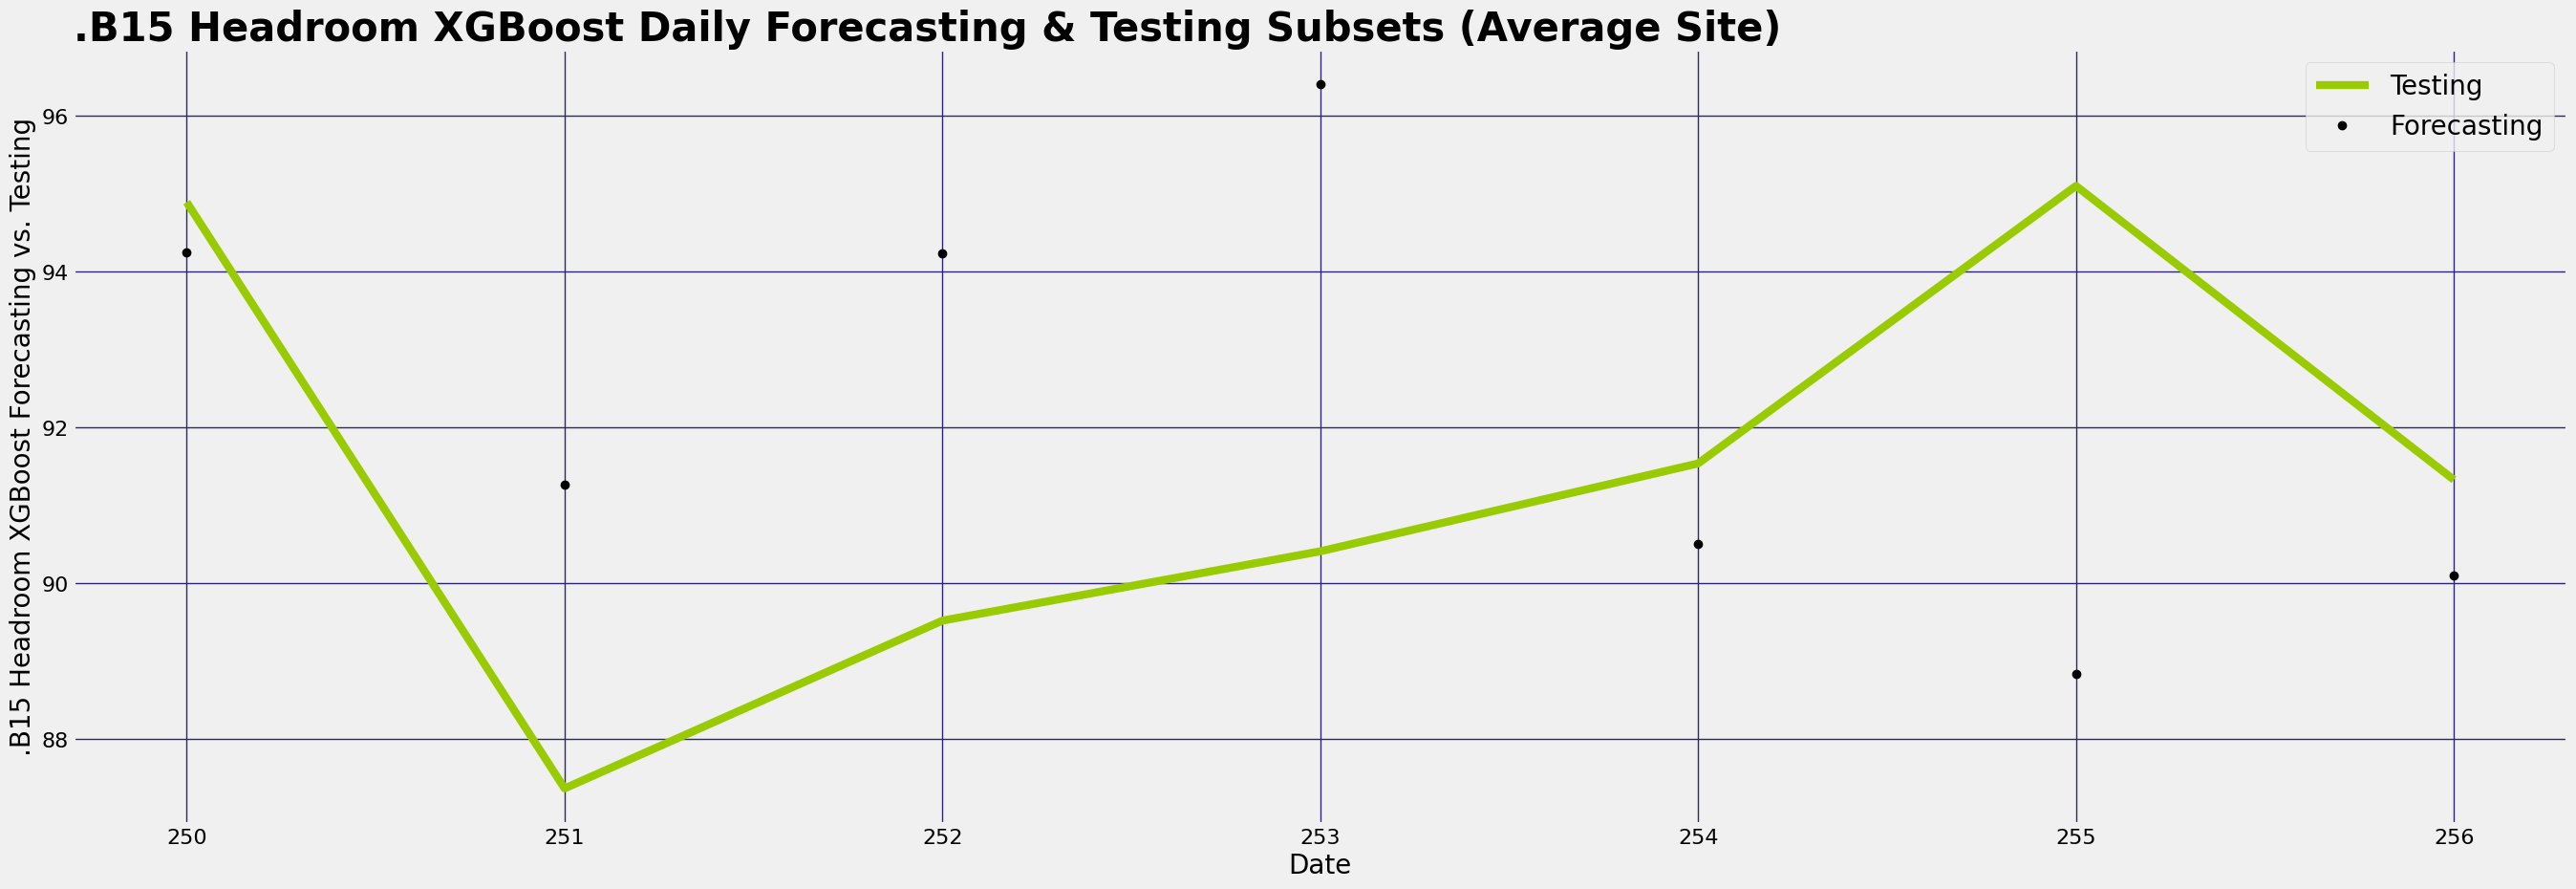

In [139]:
fname = figures_path + dependent_variable[2:len(dependent_variable)] + '_' + regressor_named + '_Daily_Forecasting_Testing_Subsets_Average_Site.png'
# Plot Forecasting vs Testing subsets

if regressor_named == "Linear Regression" or regressor_named ==  "Lasso" or regressor_named == "Ridge Regression" or regressor_named ==  "Bayesian Ridge Regression":
    
    plt.figure(figsize=(30, 10))

    plt.title(dependent_variable + ' ' + regressor_named + ' Daily Forecasting & Testing Subsets (Average Site)', fontsize=30, loc = 'left', fontweight="bold")

    x_axis = data_test[dependent_variable][:steps].index
    plt.plot(x_axis, data_test[dependent_variable][:steps], linewidth=6, color = dark_blue ) 
    plt.plot(x_axis, predictions.pred, linewidth=6, color = pale_red) 
    plt.fill_between(x_axis, predictions['lower_bound'],predictions['upper_bound'],color = pale_green,alpha = 0.2)

    plt.ylabel(dependent_variable + ' Forecasting vs. Testing', fontsize=20)
    plt.xlabel("Date", fontsize=20)


    plt.xticks(fontsize=16) 
    plt.yticks(fontsize=16)
    plt.grid(visible = True, color =brown, axis ='both')

    plt.legend(["Testing", "Forecasting"], loc='best', fontsize=20)

    plt.savefig(fname, format='png')
    
    plt.show()
    
            
elif regressor_named == "Random Forest Regressor" or regressor_named == "XGBoost":
    
    plt.figure(figsize=(30, 10))

    x_test_axis = data_test.index[:steps]
    x_fcst_axis = predictions.index[:steps]

    plt.title(dependent_variable + ' ' + regressor_named + ' Daily Forecasting & Testing Subsets (Average Site)', fontsize=30, loc = 'left', fontweight="bold")

    plt.plot(x_test_axis, data_test[dependent_variable][:steps], linewidth=6, color = pale_green)
    plt.plot(x_fcst_axis, predictions, 'ko')

    plt.ylabel(dependent_variable + ' ' + regressor_named + ' Forecasting vs. Testing', fontsize=20)
    plt.xlabel("Date", fontsize=20)

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(visible = True, color = brown, axis ='both')

    plt.legend(["Testing", "Forecasting"], loc='best', fontsize=20)

    plt.savefig(fname, format='png')

    plt.show()

In [140]:
regressor_named

'XGBoost'

In [141]:
# Forecast Error Regression Metrics
# ==============================================================================
    
if regressor_named == "Linear Regression" or regressor_named ==  "Lasso" or regressor_named == "Ridge Regression" or regressor_named ==  "Bayesian Ridge Regression": 

    # RMSE
    print("Root Mean squared error: {:.2f}".format(np.sqrt(mean_squared_error(data_test[dependent_variable][:steps], predictions.pred))))
    # MSE
    print("Mean squared error: {:.2f}".format(mean_squared_error(data_test[dependent_variable][:steps], predictions.pred)))
    # MAE
    print("Mean absolute error: {:.2f}".format(mean_absolute_error(data_test[dependent_variable][:steps], predictions.pred)))
    # R2
    print("Coefficient of determination:{:.2%}".format(r2_score(data_test[dependent_variable][:steps], predictions.pred)))
        
elif regressor_named == "Random Forest Regressor" or regressor_named == "XGBoost":

    # RMSE
    print("Root Mean squared error: {:.2f}".format(np.sqrt(mean_squared_error(data_test[dependent_variable][:steps], predictions.values))))
    # MSE
    print("Mean squared error: {:.2f}".format(mean_squared_error(data_test[dependent_variable][:steps], predictions.values)))
    # MAE
    print("Mean absolute error: {:.2f}".format(mean_absolute_error(data_test[dependent_variable][:steps], predictions.values)))
    # R2
    print("Coefficient of determination:{:.2%}".format(r2_score(data_test[dependent_variable][:steps], predictions.values)))


Root Mean squared error: 4.06
Mean squared error: 16.50
Mean absolute error: 3.40
Coefficient of determination:-147.58%


### 3.2. Hyperparameter Tuning (non-linear regressors)

_Grid_search_forecaster_ method is used with non-linear regressors (Random Forest and eXtreme Gradient Boost) in order to optimize the performance by tuning the hyperparameter selection (number of trees, max tree depth, learning rate, etc.) 

In [142]:
# Hyperparameter Grid search ---> only for not linear
# ==============================================================================

if regressor_named == "Random Forest Regressor" or regressor_named == "XGBoost":
    
    forecaster = ForecasterAutoreg(
                regressor = selected_regressor,
                lags      = lags
             )

    # Lags used as predictors
    lags_grid = [12, 24]

    # Random Forest's hyperparameters
    
        # n_estimators: The number of trees in the forest.
        # max_depth: the maximum depth of the tree. If None, then nodes are expanded until all leaves are 
                    # pure or until all leaves contain less than min_samples_split samples.
        
    # Gradient Boosting Regressor's hyperparameters
    
        # n_estimators: The number of boosting stages to perform
        # max_depth: Maximum depth of the individual regression estimators.
        # learning_rate: Learning rate shrinks the contribution of each tree by learning_rate. 
                        # There is a trade-off between learning_rate and n_estimators
    
    param_grid = {'n_estimators': [100], 'max_depth': [5, 10]}
    
    results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = data_train[dependent_variable],
                    exog        = data_train[exog_variables],
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    steps       = steps,
                    refit       = False,
                    metric      = 'mean_squared_error',
                    initial_train_size = int(len(data_train)*0.5),
                    fixed_train_size   = False,
                    return_best = True,
                    verbose     = False
                                    )
     # Grid Search results
    # ==============================================================================
    results_grid

    # Best hyperparameters

    lags_best = int(results_grid.lags[results_grid.index[0]].max())
    n_estimators_best = results_grid.n_estimators[results_grid.index[0]]
    max_depth_best = results_grid.max_depth[results_grid.index[0]]


Number of models compared: 4.


lags grid: 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 301.55235854465667



### 3.3. Final Model

Finally, the ForecasterAutoreg model is trained and a validated setting the optimal configuration



In [143]:
# Create, train, and make predictions with the best forecaster
# ============================================================
    
if regressor_named == "Random Forest Regressor" or regressor_named == "XGBoost":
    
    if regressor_named == "Random Forest Regressor":
        
        selected_regressor = RandomForestRegressor(max_depth = max_depth_best, 
                                  n_estimators = n_estimators_best, 
                                  random_state = 123)
        
        best_forecaster = ForecasterAutoreg(
                regressor = selected_regressor,
                lags      = lags_best, # lags demands for an integer that is why we used int()
                transformer_y = StandardScaler(),
                transformer_exog = StandardScaler()
             )
                
        best_forecaster.fit(y=data_test[dependent_variable], exog=data_test[exog_variables]) # training
        predictions = best_forecaster.predict(steps=steps, exog=data_predict[exog_variables])
        
    elif regressor_named == "XGBoost":
     
        selected_regressor = GradientBoostingRegressor(max_depth = max_depth_best, 
                                  n_estimators = n_estimators_best, learning_rate=0.1,
                                  random_state = 123)
     
        best_forecaster = ForecasterAutoreg(
                regressor = selected_regressor,
                lags      = lags_best, # lags demands for an integer that is why we used int()
                transformer_y = StandardScaler(),
                transformer_exog = StandardScaler()
             )

        best_forecaster.fit(y=data_test[dependent_variable], exog=data_test[exog_variables]) # training
        predictions = best_forecaster.predict(steps=steps, exog=data_predict[exog_variables])
    
    else:
    
        best_forecaster = forecaster


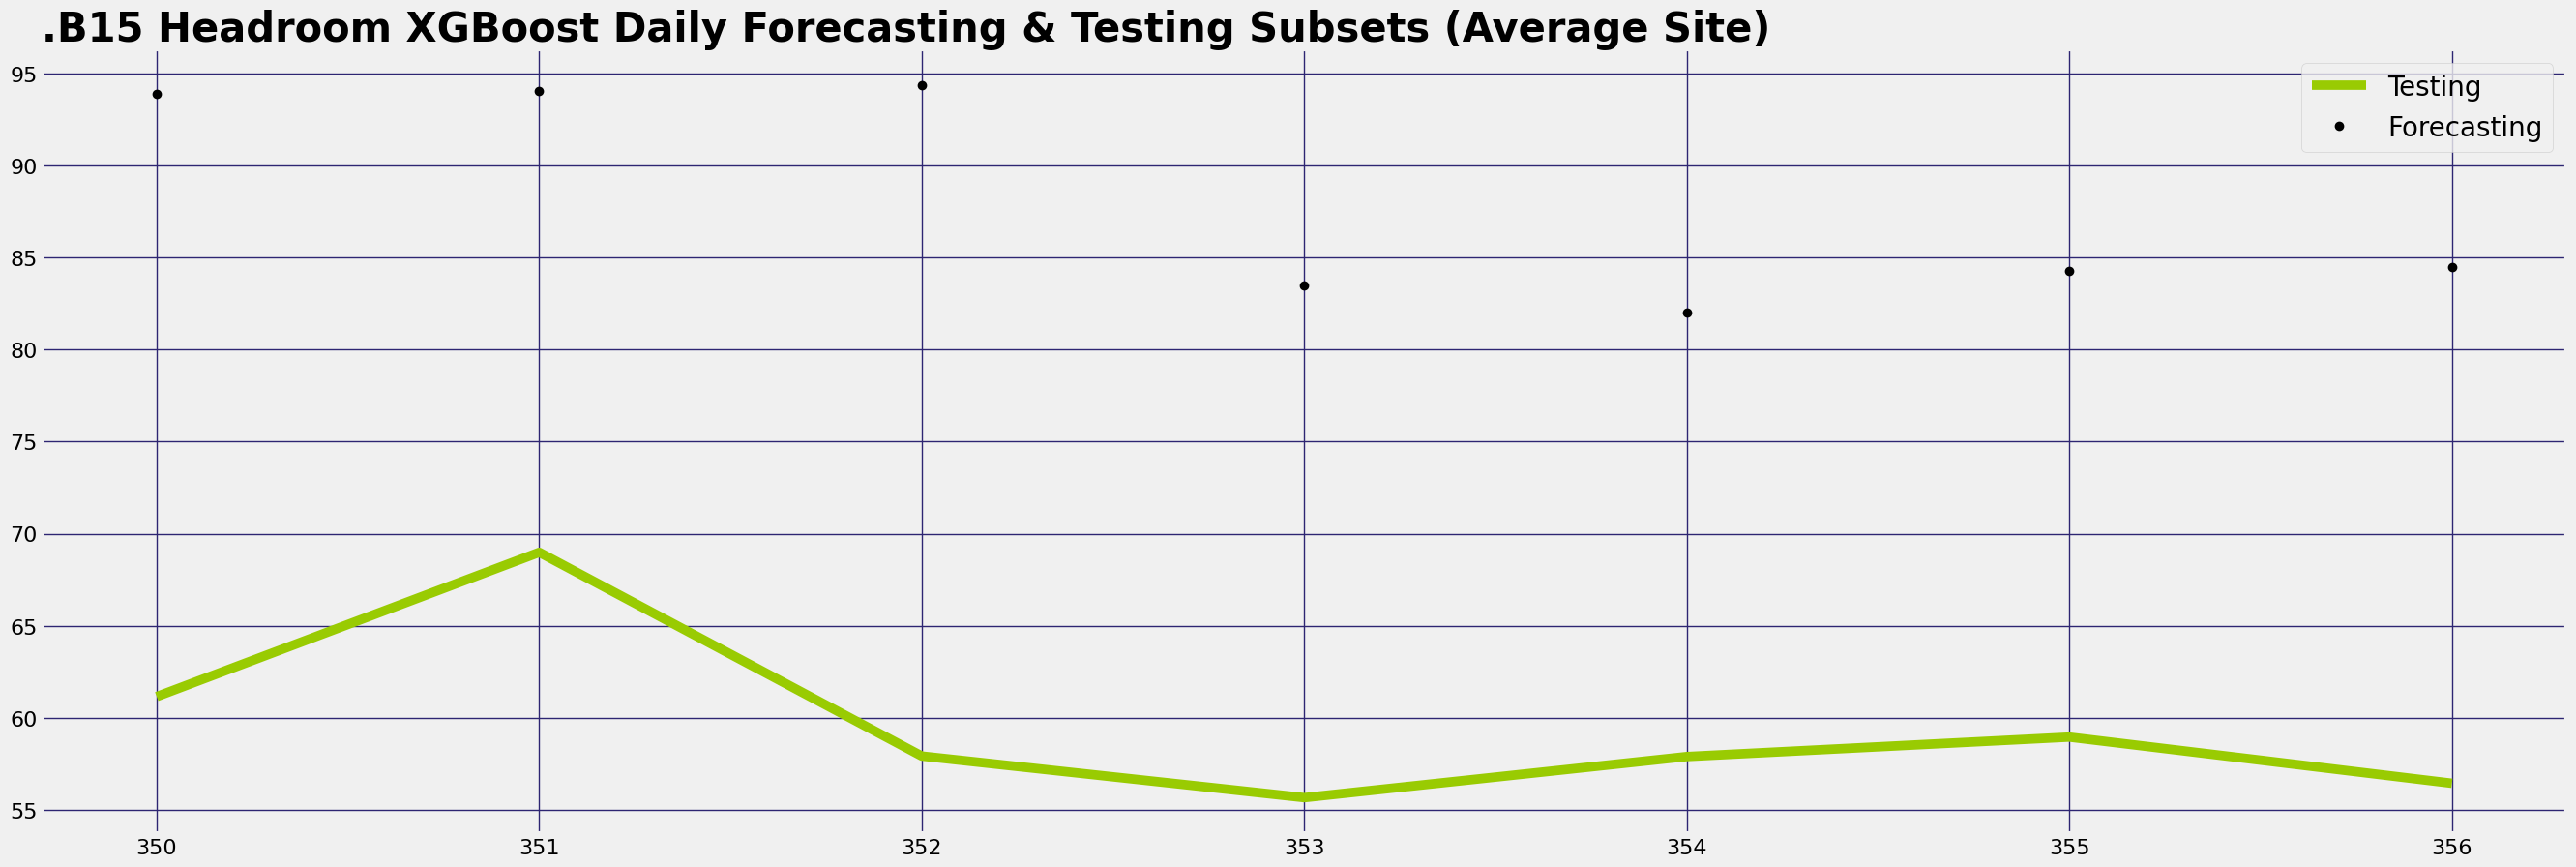

In [144]:
# Plot Forecasting with the Best Forecaster (Average Site)
# =============================================================================

if regressor_named == "Random Forest Regressor" or regressor_named == "XGBoost":

    plt.figure(figsize=(30, 10))

    x_test_axis = data_predict.index
    x_fcst_axis = predictions.index
 
    plt.title(dependent_variable + ' ' + regressor_named + ' Daily Forecasting & Testing Subsets (Average Site)', fontsize=30, loc = 'left', fontweight="bold")
    plt.plot(x_test_axis, data_predict[dependent_variable], linewidth=7.0, color = pale_green)
    plt.plot(x_fcst_axis, predictions, 'ko')

    plt.xticks(fontsize=16) 
    plt.yticks(fontsize=16)
    plt.grid(visible = True, color = brown, axis ='both')

    plt.legend(["Testing", "Forecasting"], loc='best', fontsize=20)

    fname = figures_path + dependent_variable[2:len(dependent_variable)] + '_' + regressor_named + '_Daily_Forecasting_Testing_Subsets_Average_Site.png'
    plt.savefig(fname, format='png')
    
    plt.show()

In [145]:
# Forecast Error Regression Metrics
# ==============================================================================

if regressor_named == "Random Forest Regressor" or regressor_named == "XGBoost":

    # RMSE
    print("Root Mean squared error: {:.2f}".format(np.sqrt(mean_squared_error(data_predict[dependent_variable][:steps], predictions))))
    #MSE
    print("Mean squared error: {:.2f}".format(mean_squared_error(data_predict[dependent_variable][:steps], predictions)))
    # MAE
    print("Mean absolute error: {:.2f}".format(mean_absolute_error(data_predict[dependent_variable][:steps], predictions)))
    # R2
    print("Coefficient of determination:{:.2%}".format(r2_score(data_predict[dependent_variable][:steps], predictions)))


Root Mean squared error: 28.80
Mean squared error: 829.49
Mean absolute error: 28.49
Coefficient of determination:-4655.45%


### 3.4. Backtesting

Backtesting is way of testing if a model’s predictions are in line with realised data. Backtesting a production model, for instance, is typically done by checking if actual historical production during a particular period is consistently higher, the model is underestimating production. If they are lower, the model is overestimating production.

##### Backtesting with refit and increasing training size (fixed origin)

The model is trained each time before making predictions. With this configuration, the model uses all the data available so far. It is a variation of the standard cross-validation but, instead of making a random distribution of the observations, the training set increases sequentially, maintaining the temporal order of the data.

<br>
<div>
<img src="attachment:diagram-backtesting-refit.png" width="600"/>
</div>

In the Figure we see a time series backtesting diagram with an initial training size of 10 observations, a prediction horizon of 3 steps, and retraining at each iteration. Instead of randomizing the data, this backtesting sequentially increases the size of the training set while maintaining the temporal order of the data. By doing this, the model can be tested on progressively larger amounts of historical data, providing a more accurate assessment of its predictive capabilities.

<br>
<div>
<img src="attachment:backtesting_refit.gif" width="700"/>
</div>

In [146]:
# Backtesting with refit and increasing training size (fixed origin)
# ==============================================================================

n_backtesting = steps * 3 # Backtesting is three times the forecasting horizon

if regressor_named == "Linear Regression" or regressor_named ==  "Lasso" or regressor_named == "Ridge Regression" or regressor_named ==  "Bayesian Ridge Regression":

    metric, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data_test[dependent_variable],
                            initial_train_size = len(data_test) - n_backtesting,
                            fixed_train_size   = False,
                            steps              = steps,
                            metric             = 'mean_squared_error',
                            refit              = True,
                            interval           = [1, 99],
                            n_boot             = 100,
                            verbose            = True
                            )
    print(f"Backtest error: {metric}")
    
elif regressor_named == "Random Forest Regressor" or regressor_named == "XGBoost":

    

    metric, predictions_backtest = backtesting_forecaster(
                                    forecaster         = best_forecaster,
                                    y                  = data_test[dependent_variable],
                                    exog               = data_test[exog_variables],
                                    initial_train_size = len(data_test) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    metric             = 'mean_squared_error',
                                    refit              = True,
                                    verbose            = True
                                )
    
    print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 79
Number of observations used for backtesting: 21
    Number of folds: 3
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   250 -- 328  (n=79)
    Validation: 329 -- 335  (n=7)
Fold: 1
    Training:   250 -- 335  (n=86)
    Validation: 336 -- 342  (n=7)
Fold: 2
    Training:   250 -- 342  (n=93)
    Validation: 343 -- 349  (n=7)



100%|██████████| 3/3 [00:00<00:00, 192.01it/s]


Backtest error: 147.1527599131653


In [147]:
if regressor_named == "Random Forest Regressor" or regressor_named == "XGBoost":

    # Get predictions from backtesting 
    print(predictions_backtest.tail(24))
    

          pred
329  83.746999
330  89.131270
331  73.480922
332  92.193432
333  87.071551
334  96.651575
335  73.809951
336  90.857289
337  87.521809
338  76.166440
339  79.995077
340  70.380924
341  88.230050
342  92.282710
343  88.119939
344  72.230085
345  71.010949
346  79.848575
347  80.914198
348  78.736333
349  91.713524


## 4.  Saving models

Skforecast models are stored by using save_forecaster method. Later they can be loaded with load_forecaster method

In [148]:
# Save selected regressor model with dependent and exogenous variables

if regressor_named == "Linear Regression" or regressor_named ==  "Lasso" or regressor_named == "Ridge Regression" or regressor_named ==  "Bayesian Ridge Regression":

    save_forecaster(forecaster, file_name = models_path + dependent_variable + '_' +regressor_named + '_forecaster.py', verbose=False) 
            
elif regressor_named == "Random Forest Regressor" or regressor_named == "XGBoost":

    save_forecaster(best_forecaster, file_name = models_path + dependent_variable + '_' +regressor_named + '_forecaster.py', verbose=False) 
    

In [149]:
# Computation time

time_end = time.localtime()

delta =  (time.mktime(time_end) - time.mktime(time_init)) / 60

print("Computation time = {:.2f}".format(delta), "minutes")


Computation time = 0.27 minutes


# 